# Уже готовая часть


In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.5.0+cu121  Device: cuda


In [2]:
!pip install opencv-python

In [7]:
!unzip -q data.zip -d data

In [8]:
import os
path_to_folder = './data' # путь к папке с данными
name_folders = [x[0].split('/')[-1] for x in os.walk(path_to_folder)]
name_folders = name_folders[1:]
name_folders

[')',
 ',',
 '2',
 't',
 '+',
 '-',
 '1',
 '7',
 'y',
 'times',
 '3',
 'X',
 '4',
 '0',
 '9',
 '6',
 '5',
 'w',
 '8',
 '1',
 'h',
 '(']

In [9]:
len(name_folders)

22

In [10]:
NUM_CLASSES = len(name_folders)
MAX_FILES = 1200
MIN_FILES = 1000

In [11]:
class_idx = [i for i in range(len(name_folders))]

In [12]:
dict_folders = {name_folders[i]:class_idx[i] for i in range(len(class_idx))}

In [13]:
dict_folders

{')': 0,
 ',': 1,
 '2': 2,
 't': 3,
 '+': 4,
 '-': 5,
 '1': 19,
 '7': 7,
 'y': 8,
 'times': 9,
 '3': 10,
 'X': 11,
 '4': 12,
 '0': 13,
 '9': 14,
 '6': 15,
 '5': 16,
 'w': 17,
 '8': 18,
 'h': 20,
 '(': 21}

In [14]:
file_names = []
class_labels = []
for path, subdirs, files in os.walk(path_to_folder):
    for name in files:
        file_names.append(os.path.join(path, name))
        class_labels.append(dict_folders[path.split('/')[-1]])

In [15]:
import pandas as pd
import skimage
from skimage import io,morphology
from PIL import Image, ImageOps
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
from torchvision import transforms
from random import shuffle
import cv2

class NumericDataset(Dataset):

    def __init__(self, root_dir, img_size, num_classes, transform = None):
        self.root_dir = root_dir
        self.img_size = img_size # !!! внимательно при изменении размеров изображения
        self.transform = transform
        self.num_classes = num_classes
        file_names = []
        class_labels = []
        for path, subdirs, files in os.walk(path_to_folder):
            for (idx,name) in enumerate(files):
                if(idx < MAX_FILES and idx > MIN_FILES):
                    file_names.append(os.path.join(path, name))
                    class_labels.append(dict_folders[path.split('/')[-1]])
        self.files = [[file_names[i],class_labels[i]] for i in range(len(file_names))]#!!!
        shuffle(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx][0]

        img = cv2.imread(img_name, cv2.COLOR_RGB2GRAY)
        image = img
        #kernel = np.ones((5,5),np.uint8)
        #image = 255 - img #inverting
        #image = cv2.erode(img,kernel,iterations = 1)
        #image = Image.open(img_name)
        image = cv2.resize(image,(self.img_size, self.img_size))
        image = cv2.bitwise_not(image) / 255
        #image[image == 0] = 1
        #image[image==0] = -1
        #image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = np.asarray(image).astype(float)#.reshape(3,self.img_size,self.img_size)
        #image = np.dstack([image,image,image])

        #image =  (1 - (torch.from_numpy(image)/255.0)) * 2 -1

        target = [0 for i in range(self.num_classes)]
        target[self.files[idx][1]] = 1
        target = torch.FloatTensor(target)

        image = torch.FloatTensor(image[:,:,0])
        if self.transform:
            image = self.transform(image)

        return image,target,self.files[idx][1]

In [16]:
from torch.utils.data import DataLoader
from torchvision import transforms
#transforms = torch.nn.Sequential(
#    transforms.Resize((28,28))
#)
batch_size = (MAX_FILES-MIN_FILES)*NUM_CLASSES
IMAGE_SIZE = 32
num_train_dataloader = DataLoader(NumericDataset(path_to_folder,IMAGE_SIZE,NUM_CLASSES), batch_size=batch_size, shuffle=True)

In [17]:
for (X_train, y_train,class_idx) in num_train_dataloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([3781, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([3781, 22]) type: torch.FloatTensor


In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(IMAGE_SIZE*IMAGE_SIZE, 4*IMAGE_SIZE*IMAGE_SIZE)
        #self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(4*IMAGE_SIZE*IMAGE_SIZE, 4*NUM_CLASSES)
        #self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(4*NUM_CLASSES, NUM_CLASSES)

    def forward(self, x):
        x = x.view(-1, IMAGE_SIZE*IMAGE_SIZE)
        #x = F.sigmoid(self.fc1(x))
        x = self.fc1(x)
        #x = self.fc1_drop(x)
        #x = F.sigmoid(self.fc2(x))
        x = self.fc2(x)
        #x = self.fc2_drop(x)
        #return F.softmax(self.fc3(x), dim=1)
        return self.fc3(x)


# Домашняя часть

In [ ]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ
#Часть символов оставить для обучения классификатора. Остальные  классифицировать
#по аналогии с примером mnist с  прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор.
# Варьировать только k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.


#Генерация набора даннах

In [19]:
import random
import os

path_to_folder = './data' # путь к папке с данными
name_folders = [x[0].split('/')[-1] for x in os.walk(path_to_folder)]
name_folders = name_folders[1:]
name_folders.remove('times')

name_folders

[')',
 ',',
 '2',
 't',
 '+',
 '-',
 '1',
 '7',
 'y',
 '3',
 'X',
 '4',
 '0',
 '9',
 '6',
 '5',
 'w',
 '8',
 '1',
 'h',
 '(']

Сгенерированная последовательность: 75Xh71
Последовательность с пробелами: 7 5 X h 7 1 


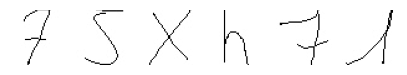

In [20]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Допустимые символы
allowed_symbols = name_folders  # Предполагается, что name_folders определен ранее

# Генерация последовательности символов
def generate_random_sequence(length=6):
    return ''.join(random.choices(allowed_symbols, k=length))

# Присвоение каждому символу папки с изображениями
def find_random_images(sequence, allowed_symbols):
    result = []
    for symbol in sequence:
        if symbol in allowed_symbols:
            images_list = os.listdir(f"./data/{symbol}")
            filtered_images = [img for img in images_list if img.startswith(f"{symbol}_")]
            if filtered_images:  # Если есть изображения, выбираем случайное
                random_image = random.choice(filtered_images)
                result.append(f"./data/{symbol}/{random_image}")
    return result

# Функция добавления пробелов
def add_spaces(sequence):
    spaced_sequence = []
    for symbol in sequence:
        spaced_sequence.append(symbol)
        spaced_sequence.append(' ')
    return ''.join(spaced_sequence)

# Генерация последовательности
generated_sequence = generate_random_sequence()
print("Сгенерированная последовательность:", generated_sequence)

# Добавляем пробелы к сгенерированной последовательности
spaced_sequence = add_spaces(generated_sequence)
print("Последовательность с пробелами:", spaced_sequence)

# Получаем случайные изображения
image_paths = find_random_images(generated_sequence, allowed_symbols)

# Визуализация изображений
plt.figure(figsize=(5, 3))
for idx, img_path in enumerate(image_paths):
    img = mpimg.imread(img_path)
    plt.subplot(1, len(image_paths), idx + 1)
    plt.imshow(img, cmap='gray')  # Отображение в чёрно-белом
    plt.axis('off')  # Отключаем оси
plt.show()


#Классификация

Папка ')': выбрано 900 изображений для обучения и 500 для тестирования.
Папка ',': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '2': выбрано 900 изображений для обучения и 500 для тестирования.
Папка 't': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '+': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '-': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '1': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '7': выбрано 900 изображений для обучения и 500 для тестирования.
Папка 'y': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '3': выбрано 900 изображений для обучения и 500 для тестирования.
Папка 'X': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '4': выбрано 900 изображений для обучения и 500 для тестирования.
Папка '0': выбрано 900 изображений для обучения и 500 для тестирования.
Недостаточно изображений в папке '9' для выборки.
Папка '6': выб

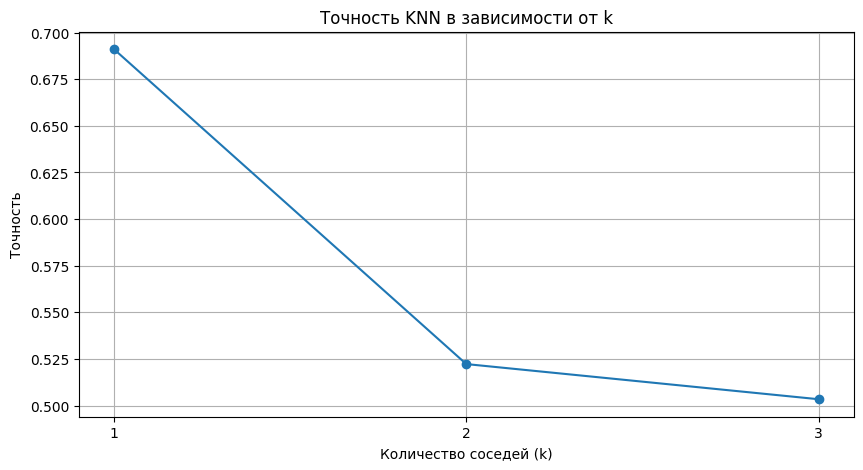

In [34]:
# Импортируем необходимые библиотеки
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Шаг 1: Подготовка данных
def load_images_from_folder(folder, num_train_per_class=900, num_test_per_class=500):
    images = []
    labels = []

    # Проходим по каждой папке, название которой соответствует символу
    for label in os.listdir(folder):
        if label in allowed_symbols:  # Проверяем, что папка является допустимым символом
            label_folder = os.path.join(folder, label)
            # Собираем все изображения в папке
            all_images = [os.path.join(label_folder, filename) for filename in os.listdir(label_folder)
                          if os.path.isfile(os.path.join(label_folder, filename)) and
                          (filename.endswith('.png') or filename.endswith('.jpg'))]

            # Проверяем, что в папке достаточно изображений
            if len(all_images) >= num_train_per_class + num_test_per_class:
                # Случайная выборка 100 изображений для обучения и 300 для тестирования
                selected_images = random.sample(all_images, num_train_per_class + num_test_per_class)
                train_images = selected_images[:num_train_per_class]
                test_images = selected_images[num_train_per_class:]

                # Выводим информацию о количестве выбранных изображений для каждой папки
                print(f"Папка '{label}': выбрано {len(train_images)} изображений для обучения и {len(test_images)} для тестирования.")

                # Добавляем изображения для обучения
                for img_path in train_images:
                    img = mpimg.imread(img_path)
                    img_vector = img.flatten()  # Преобразуем изображение в вектор
                    images.append(img_vector)
                    labels.append(label)

                # Добавляем изображения для тестирования
                for img_path in test_images:
                    img = mpimg.imread(img_path)
                    img_vector = img.flatten()  # Преобразуем изображение в вектор
                    images.append(img_vector)
                    labels.append(label)
            else:
                print(f"Недостаточно изображений в папке '{label}' для выборки.")

    return np.array(images), np.array(labels)

# Загрузка изображений
X, y = load_images_from_folder('./data')

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 2: Обучение классификатора KNN
k_values = range(1, 4)  # Параметр k от 1 до 3
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Точность для k={k}: {accuracy:.2f}")

# Шаг 3: Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title('Точность KNN в зависимости от k')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.xticks(k_values)
plt.grid()
plt.show()



Сгенерированная последовательность: hh9,37
Распознанный текст: hh)137
Изменённая последовательность: h)w1373
CER: 0.6666666666666666


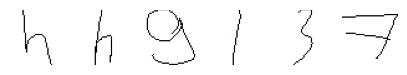

In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Определение функций
def modify_text(text, max_changes=3):
    text_list = list(text)
    changes = random.randint(1, max_changes)

    for _ in range(changes):
        action = random.choice(['add', 'remove'])
        if action == 'add':
            random_symbol = random.choice(allowed_symbols)
            position = random.randint(0, len(text_list))
            text_list.insert(position, random_symbol)
        elif action == 'remove' and text_list:
            position = random.randint(0, len(text_list) - 1)
            del text_list[position]

    return ''.join(text_list)

def calculate_cer(original, modified):
    n = len(original)
    m = len(modified)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        for j in range(m + 1):
            if i == 0:
                dp[i][j] = j  # Все добавления
            elif j == 0:
                dp[i][j] = i  # Все удаления
            elif original[i - 1] == modified[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]  # Символы совпадают
            else:
                dp[i][j] = min(dp[i - 1][j] + 1,     # Удаление
                               dp[i][j - 1] + 1,     # Добавление
                               dp[i - 1][j - 1] + 1) # Замена

    edits = dp[n][m]
    cer = edits / n if n > 0 else 0
    return cer


# Генерация последовательности
generated_sequence = generate_random_sequence()
print("Сгенерированная последовательность:", generated_sequence)

# Шаг 2: Получение изображений для распознавания
image_paths = find_random_images(generated_sequence, allowed_symbols)

# Шаг 3: Предсказание символов
def recognize_characters(image_paths):
    recognized_text = []
    for img_path in image_paths:
        img = mpimg.imread(img_path)
        img_vector = img.flatten().reshape(1, -1)  # Преобразуем изображение в вектор
        prediction = knn.predict(img_vector)  # Предсказание символа
        recognized_text.append(prediction[0])  # Добавляем предсказанный символ
    return ''.join(recognized_text)

# Распознаем символы
recognized_text = recognize_characters(image_paths)
print("Распознанный текст:", recognized_text)

# Шаг 4: Изменение текста
modified_sequence = modify_text(recognized_text)
print("Изменённая последовательность:", modified_sequence)

# Рассчитываем CER
cer_value = calculate_cer(generated_sequence, modified_sequence)
print("CER:", cer_value)

# Шаг 5: Визуализация изображений
plt.figure(figsize=(5, 3))
for idx, img_path in enumerate(image_paths):
    img = mpimg.imread(img_path)
    plt.subplot(1, len(image_paths), idx + 1)
    plt.imshow(img, cmap='gray')  # Отображение в чёрно-белом
    plt.axis('off')  # Отключаем оси
plt.show()
